In [14]:
from data.dataset_generator import generate_dataset
from data.dataset import TripletFaceDataset
from torchvision.transforms import v2 as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from models.facenet_vgg16 import FaceNetVGG16
import torch
from helpers.trainer import train_one_epoch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
df = generate_dataset("E:\\105_classes_pins_dataset")

In [9]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomAdjustSharpness(sharpness_factor=2.0, p=0.12),
    transforms.RandomAutocontrast(p=0.13)
])

dataset = TripletFaceDataset(df, transform)
dataloader = DataLoader(
    dataset, 
    batch_size=10,
    shuffle=True,
    num_workers=4
)

In [10]:
def visualize_data_item(batch, sample):
    labels = ["anchor", "positive", "negative"]
    for i, label in enumerate(labels):
        plt.subplot(1, 3, i+1)
        plt.imshow(batch[i][sample].permute(1, 2, 0))
        plt.axis('off')
        plt.title(label)
    plt.show()

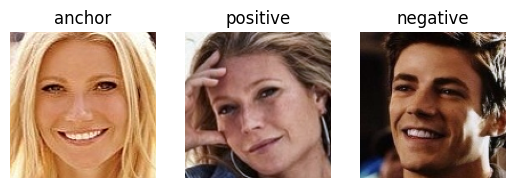

In [11]:
sample_data = next(iter(dataloader))
visualize_data_item(sample_data, 2)

In [15]:
EPOCHS = 10

model = FaceNetVGG16(embed_layer_size=128, dropout=0.3).to(device)

loss_fn = torch.nn.TripletMarginLoss(margin=0.3)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

for epoch in range(EPOCHS):
    print(f'EPOCH {epoch+1} / {EPOCHS}')
    model.train(True)
    model, pos_dist, neg_dist, avg_loss, avg_acc = train_one_epoch(model, optimizer, loss_fn, dataloader, device)
    torch.save(model.state_dict(), f"model_{epoch+1}.pt")
    print(f"Epoch loss: {avg_loss}")

C:\Users\ponak\PycharmProjects\FaceNet\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ponak\PycharmProjects\FaceNet\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EPOCH 1 / 10


RuntimeError: Input type (unsigned char) and bias type (float) should be the same